In [ ]:
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# DATA UTILITIES


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATASET_DIR = "drive/MyDrive/Corona_chest_xray/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

In [ ]:
df = pd.read_csv("drive/MyDrive/Corona_chest_xray/Chest_xray_Corona_Metadata.csv")
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
df.fillna('unknown', inplace=True)
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown


In [ ]:
train=df[(df['Dataset_type']=='TRAIN') & ((df['Label']=='Normal') | ((df['Label']=='Pnemonia') & (df['Label_1_Virus_category']=='Virus')))]
test=df[(df['Dataset_type']=='TEST') & ((df['Label']=='Normal') | ((df['Label']=='Pnemonia')))]
Ftest=df[(df['Dataset_type']=='FTEST')]
lab=test['Label']

In [ ]:
print(len(train))
print(len(test))
print(len(Ftest))

2749
624
0


In [ ]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 10
BATCH_SIZE = 6

In [ ]:
train_data = []
test_data = []
final_test_data=[]

for (i,img) in train.iterrows():
    try:
        img_path = os.path.join(DATASET_DIR+'/train',img['X_ray_image_name'])
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array,(IMG_W,IMG_H))/255.0
        if img['Label'] == 'Normal':
            train_data.append([img_array,0])
        else:
            train_data.append([img_array,1])
    except Exception as e:
        pass

for (i,img) in test.iterrows():
    try:
        img_path = os.path.join(DATASET_DIR+'/test',img['X_ray_image_name'])
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array,(IMG_W,IMG_H))/255.0
        if img['Label'] == 'Normal':
            test_data.append([img_array,0])
        else:
            test_data.append([img_array,1])
    except Exception as e:
        pass
        
print(len(train_data))    

In [ ]:
train_data=train_data[:2000]
print(len(test_data))
final_test=[]
for (i,img) in Ftest.iterrows():
    try:
        img_path = os.path.join(DATASET_DIR+'/FTEST',img['X_ray_image_name'])
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array,(IMG_W,IMG_H))/255.0
        final_test.append(img_array)
    except Exception as e:
        pass

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

for (feature,target) in train_data:
    x_train.append(feature)
    y_train.append(target)
    
for (feature,target) in test_data:
    x_test.append(feature)
    y_test.append(target)

NameError: ignored

In [ ]:
#sample images of normal

samp_img1 = x_train[0]
samp_img2 = x_train[15]
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1, cmap='gray');
ax[1].imshow(samp_img2, cmap='gray');

NameError: ignored

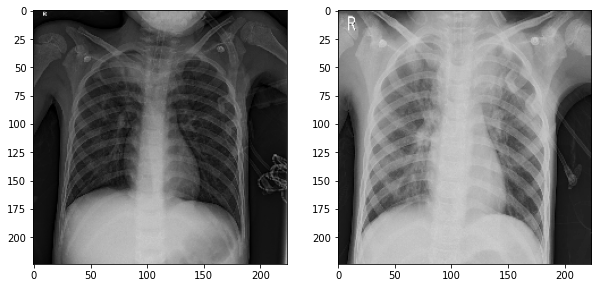

In [ ]:
#sample image of covid

covid_df = train[(train['Label']=='Pnemonia') & (train['Label_1_Virus_category']=='Virus')]
f=0
covid_img = []
for (i,img) in covid_df.iterrows():
  if(f==2):
    break
  f = f+1
  try:
      img_path = os.path.join(DATASET_DIR+'/train',img['X_ray_image_name'])
      img_array = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
      img_array = cv2.resize(img_array,(IMG_W,IMG_H))/255.0
      covid_img.append(img_array)
  except Exception as e:
      pass


fig1, ax1 =plt.subplots(1,2, figsize=(10,5))
ax1[0].imshow(covid_img[0], cmap='gray');
ax1[1].imshow(covid_img[1], cmap='gray');

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# DATA AUGMENTATION

In [ ]:
#create a imagegenerator for for augmentation
datagen =  ImageDataGenerator(
  width_shift_range=0.2,
  #brightness_range=[0.5, 1.5],
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

# function to convert image to array
def read_img(filename, size, path):
    img = load_img(os.path.join(path, filename), target_size=size)
    #convert image to array
    img = img_to_array(img) / 255
    return img


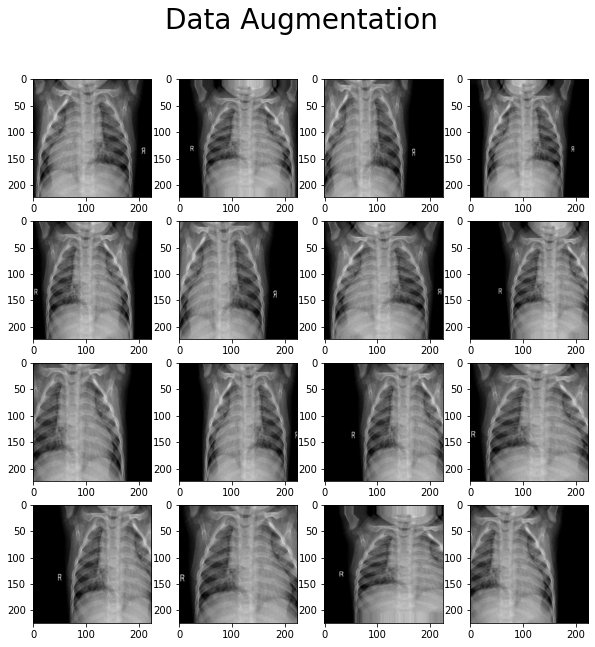

In [ ]:
#read a sample image
samp_img = read_img(train['X_ray_image_name'][0],
                                 (224,224),
                                 DATASET_DIR+'/train')

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
#show augmented images
for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=6):
    plt.subplot(4, 4, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(224, 224, 3))
    if i == 15:
        break
    i += 1
plt.show();

# CNN MODEL

In [ ]:
mob_model = Sequential()
mob_model.add(tf.keras.applications.MobileNetV2(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224,224,3), classes=2))
mob_model.add(Dense(32, activation='relu'))
mob_model.add(Dense(1, activation='sigmoid'))
mob_model.layers[0].trainable = False
mob_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mob_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history = mob_model.fit(x_train,y_train,batch_size=16,epochs = 20,validation_split = 0.25)

Epoch 1/20
94/94 [==============================] - 4s 38ms/step - loss: 0.1700 - accuracy: 0.9420 - val_loss: 0.9656 - val_accuracy: 0.6000
Epoch 2/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0878 - accuracy: 0.9680 - val_loss: 0.2428 - val_accuracy: 0.9100
Epoch 3/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0692 - accuracy: 0.9733 - val_loss: 1.0786 - val_accuracy: 0.6260
Epoch 4/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0562 - accuracy: 0.9800 - val_loss: 0.3956 - val_accuracy: 0.8540
Epoch 5/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0443 - accuracy: 0.9873 - val_loss: 0.6031 - val_accuracy: 0.8000
Epoch 6/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.4974 - val_accuracy: 0.8380
Epoch 7/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.5065 - val_accuracy: 0.8420
Epoch 8/20
94

# PREDICTION

In [ ]:
x_test=np.array(x_test)
y_test=np.array(y_test)
test_loss, test_acc = mob_model.evaluate(x_test,y_test)

In [ ]:
print(test_loss,test_acc)

0.6377431154251099 0.8653846383094788


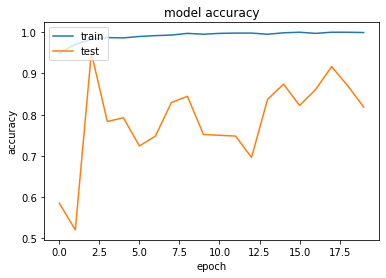

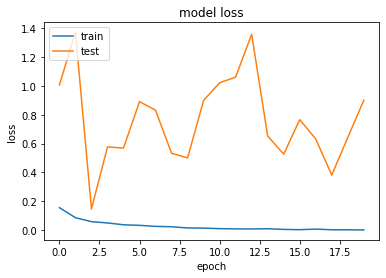

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = mob_model.predict_classes(x_test)
final_pred=mob_model.predict_classes(np.array(final_test))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       234
           1       0.89      0.90      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.86       624
weighted avg       0.86      0.87      0.87       624



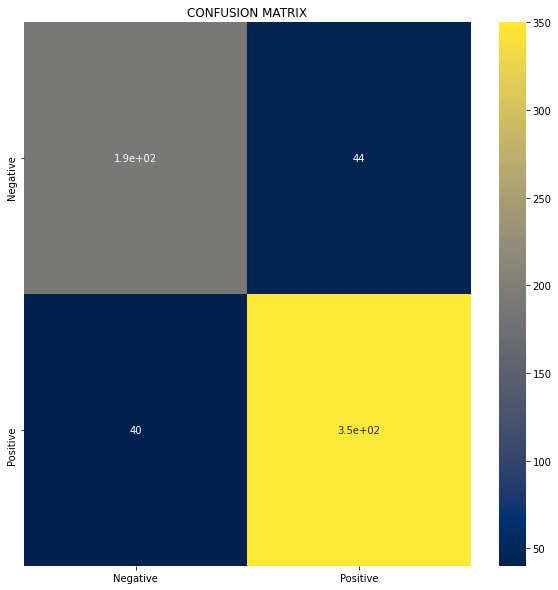

In [ ]:
import seaborn as sns
con_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='cividis',
            yticklabels=['Negative', 'Positive'],
            xticklabels=['Negative', 'Positive'],
            annot=True);

# OUTPUT FILE 

In [ ]:
test['class'] = test.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test['target'] = test.Label.apply(lambda x: 0 if x=='Normal' else 1)
test = test[['X_ray_image_name', 'class', 'target']]
test['predicted value']=y_pred
test['Label_of_image']=lab
test.head()
test.to_csv('OUTPUT_OF_TEST_with_0.86.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Ftest['Predicted_value']=final_pred
Ftest['Class'] = Ftest.Predicted_value.apply(lambda x: 'negative' if x==0 else 'positive')
Ftest['Label'] = Ftest.Predicted_value.apply(lambda x: 'Normal' if x==0 else 'Pnuemonia')
Ftest=Ftest[['X_ray_image_name', 'Class','Label', 'Predicted_value']]
Ftest.to_csv("Final_test.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
